In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')


In [2]:
import pickle
with open('/srv/scratch/z5297792/Sample/sample_data_CE4.pkl', 'rb') as file: # CE8-SSIMCS, CE4-SSIMCS/TA, AE22-SSIMTA, AE2377-SSIMCS/TA
    sample_data = pickle.load(file)
    
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [3]:
eddy = list(sample_data.keys())
print(eddy)
print(sample_data[eddy[0]].keys())
eddy = eddy[0]

['Eddy4']
dict_keys(['U', 'V', 'TA', 'CS', 'OW', 'VG', 'LNAM', 'COW', 'SSIM', 'SSIMCS'])


In [4]:
# fake = {}
# for t in range(30):
#     fake['T'+str(t)] = pd.DataFrame({'x': [np.nan, np.nan], 'y': [np.nan, np.nan], 'Depth': [np.nan, np.nan],})
# sample_data[eddy]['SSIMCS'] = fake

In [5]:
def process_eddy_data(sample_data, eddy, z_r, depth_lvl_limit, method):
    # Initialize empty DataFrames
    x_df = pd.DataFrame()
    y_df = pd.DataFrame()
    x_diff_df = pd.DataFrame()
    y_diff_df = pd.DataFrame()
    TD_df = pd.DataFrame()
    D_df = pd.DataFrame()

    for i, time_data in enumerate(sample_data[eddy][method].values()):
        x = time_data['x'] - time_data.iloc[0]['x']
        if len(x) < depth_lvl_limit:
            nans_to_add = max(0, depth_lvl_limit - len(x))
            x = pd.concat([x, pd.Series([np.nan] * nans_to_add)], ignore_index=True)
        x_df['x'+str(i)] = x
        x_diff_df['x'+str(i)] = x.diff() / np.insert(np.diff(-z_r), 0, np.nan)

        y = time_data['y'] - time_data.iloc[0]['y']
        if len(y) < depth_lvl_limit:
            nans_to_add = max(0, depth_lvl_limit - len(y))
            y = pd.concat([y, pd.Series([np.nan] * nans_to_add)], ignore_index=True)
        y_df['y'+str(i)] = y
        y_diff_df['y'+str(i)] = y.diff() / np.insert(np.diff(-z_r), 0, np.nan)

        TD_df['TD'+str(i)] = np.sqrt(x**2 + y**2)
        D_df['D'+str(i)] = np.sqrt(x.diff()**2 + y.diff()**2) / np.insert(np.diff(-z_r), 0, np.nan)

    for df, diff_df, axis_label in [(x_df, x_diff_df, 'x'), (y_df, y_diff_df, 'y'), (TD_df, TD_df, 'TD'), (D_df, D_df, 'D')]:

        mean = df.mean(axis=1)
        std = df.std(axis=1)

        mean_diff = diff_df.mean(axis=1)
        std_diff = diff_df.std(axis=1)

        df['Depth'] = z_r * 1000
        diff_df['Depth'] = z_r * 1000

        df['Mean'] = mean
        df['StdDev'] = std

        diff_df['Mean'] = mean_diff
        diff_df['StdDev'] = std_diff

    return x_df, y_df, x_diff_df, y_diff_df, TD_df, D_df


In [7]:
DEPTH_LVL_LIMIT = 23
VG_x_df, VG_y_df, VG_x_diff_df, VG_y_diff_df, VG_TD_df, VG_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'VG')

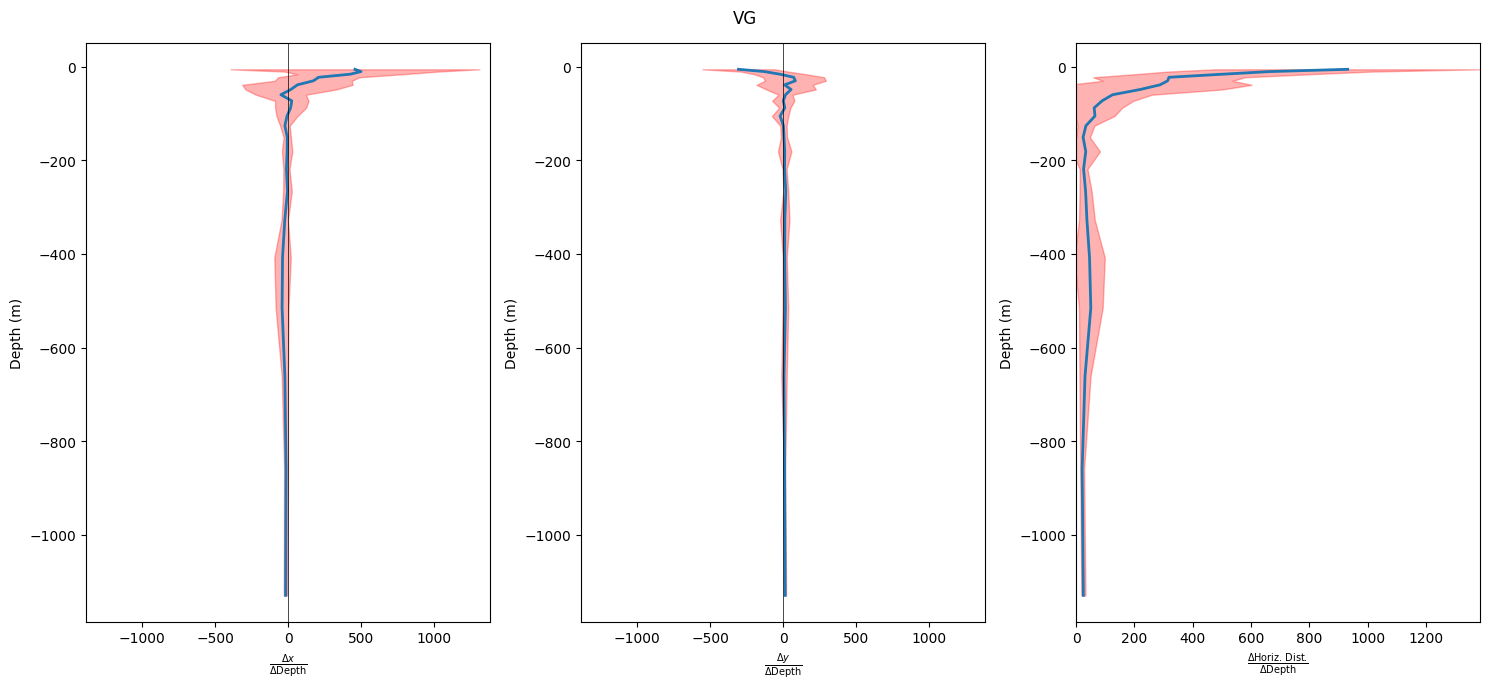

In [8]:
max_x_value = max(
    np.nanmax(abs(VG_x_diff_df['Mean'] + VG_x_diff_df['StdDev'])),
    np.nanmax(abs(VG_y_diff_df['Mean'] + VG_y_diff_df['StdDev'])),
    np.nanmax(abs(VG_D_df['Mean'] + VG_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(VG_x_diff_df['Mean'], VG_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(VG_x_diff_df['Depth'], VG_x_diff_df['Mean'] - VG_x_diff_df['StdDev'], VG_x_diff_df['Mean'] + VG_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(VG_y_diff_df['Mean'], VG_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(VG_y_diff_df['Depth'], VG_y_diff_df['Mean'] - VG_y_diff_df['StdDev'], VG_y_diff_df['Mean'] + VG_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(VG_D_df['Mean'], VG_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(VG_D_df['Depth'], VG_D_df['Mean'] - VG_D_df['StdDev'], VG_D_df['Mean'] + VG_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('VG')
plt.tight_layout()
plt.show()

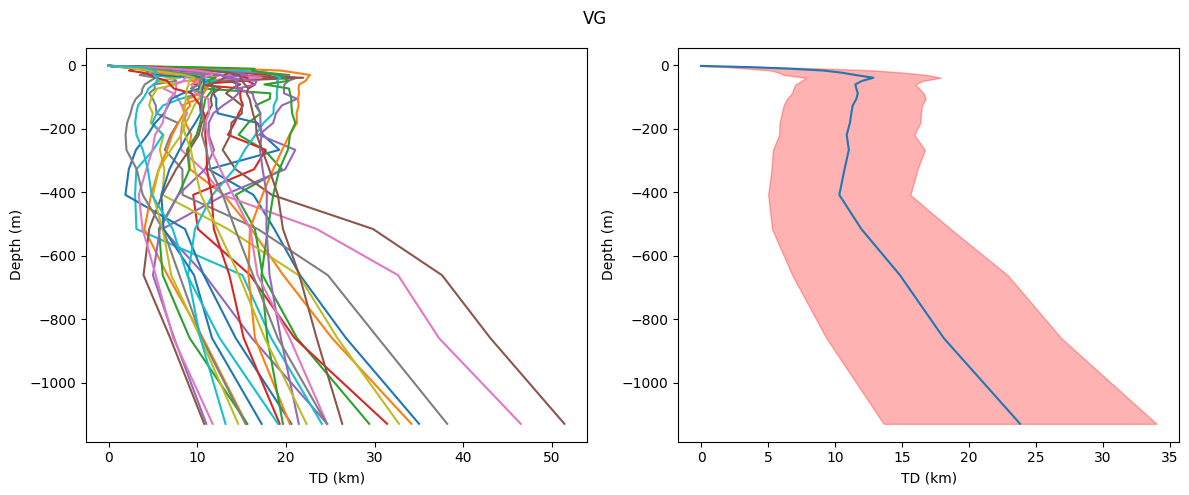

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in VG_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(VG_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(VG_TD_df['Mean'], VG_TD_df['Depth'])
axs[1].fill_betweenx(VG_TD_df['Depth'], VG_TD_df['Mean'] - VG_TD_df['StdDev'], VG_TD_df['Mean'] + VG_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('VG')
plt.tight_layout()
plt.show()


In [10]:
LNAM_x_df, LNAM_y_df, LNAM_x_diff_df, LNAM_y_diff_df, LNAM_TD_df, LNAM_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'LNAM')

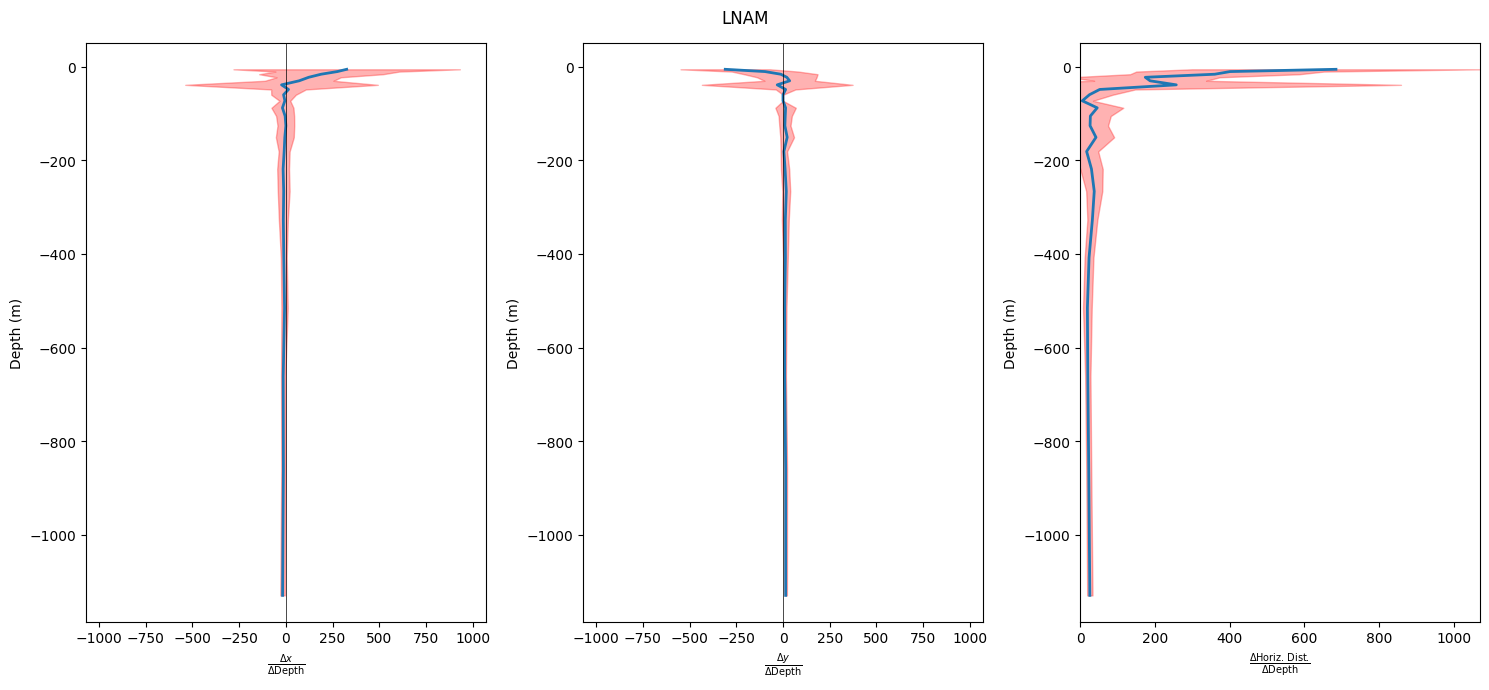

In [11]:
max_x_value = max(
    np.nanmax(abs(LNAM_x_diff_df['Mean'] + LNAM_x_diff_df['StdDev'])),
    np.nanmax(abs(LNAM_y_diff_df['Mean'] + LNAM_y_diff_df['StdDev'])),
    np.nanmax(abs(LNAM_D_df['Mean'] + LNAM_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(LNAM_x_diff_df['Mean'], LNAM_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(LNAM_x_diff_df['Depth'], LNAM_x_diff_df['Mean'] - LNAM_x_diff_df['StdDev'], LNAM_x_diff_df['Mean'] + LNAM_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(LNAM_y_diff_df['Mean'], LNAM_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(LNAM_y_diff_df['Depth'], LNAM_y_diff_df['Mean'] - LNAM_y_diff_df['StdDev'], LNAM_y_diff_df['Mean'] + LNAM_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(LNAM_D_df['Mean'], LNAM_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(LNAM_D_df['Depth'], LNAM_D_df['Mean'] - LNAM_D_df['StdDev'], LNAM_D_df['Mean'] + LNAM_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('LNAM')
plt.tight_layout()
plt.show()

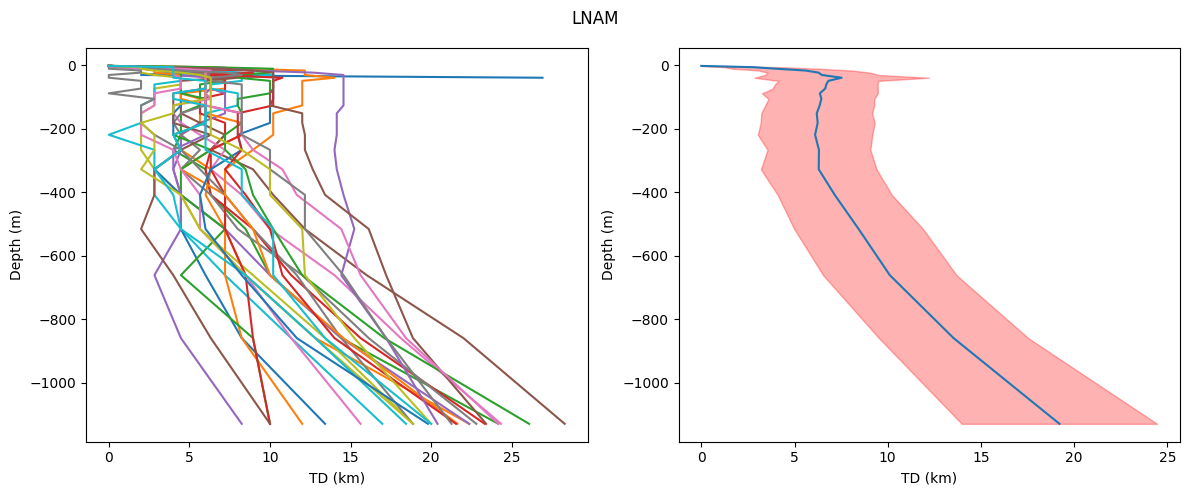

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in LNAM_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(LNAM_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(LNAM_TD_df['Mean'], LNAM_TD_df['Depth'])
axs[1].fill_betweenx(LNAM_TD_df['Depth'], LNAM_TD_df['Mean'] - LNAM_TD_df['StdDev'], LNAM_TD_df['Mean'] + LNAM_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('LNAM')
plt.tight_layout()
plt.show()

In [13]:
COW_x_df, COW_y_df, COW_x_diff_df, COW_y_diff_df, COW_TD_df, COW_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'COW')


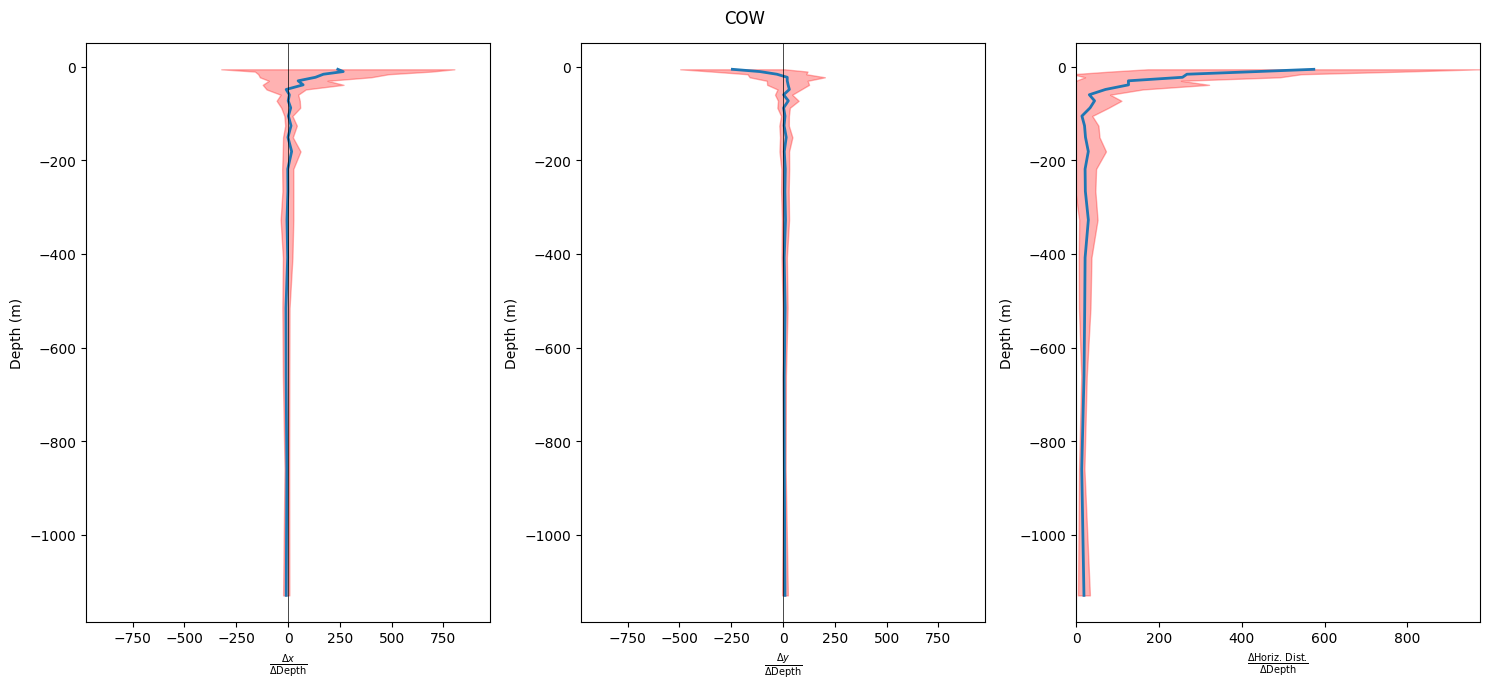

In [14]:
max_x_value = max(
    np.nanmax(abs(COW_x_diff_df['Mean'] + COW_x_diff_df['StdDev'])),
    np.nanmax(abs(COW_y_diff_df['Mean'] + COW_y_diff_df['StdDev'])),
    np.nanmax(abs(COW_D_df['Mean'] + COW_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(COW_x_diff_df['Mean'], COW_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(COW_x_diff_df['Depth'], COW_x_diff_df['Mean'] - COW_x_diff_df['StdDev'], COW_x_diff_df['Mean'] + COW_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(COW_y_diff_df['Mean'], COW_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(COW_y_diff_df['Depth'], COW_y_diff_df['Mean'] - COW_y_diff_df['StdDev'], COW_y_diff_df['Mean'] + COW_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(COW_D_df['Mean'], COW_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(COW_D_df['Depth'], COW_D_df['Mean'] - COW_D_df['StdDev'], COW_D_df['Mean'] + COW_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('COW')
plt.tight_layout()
plt.show()

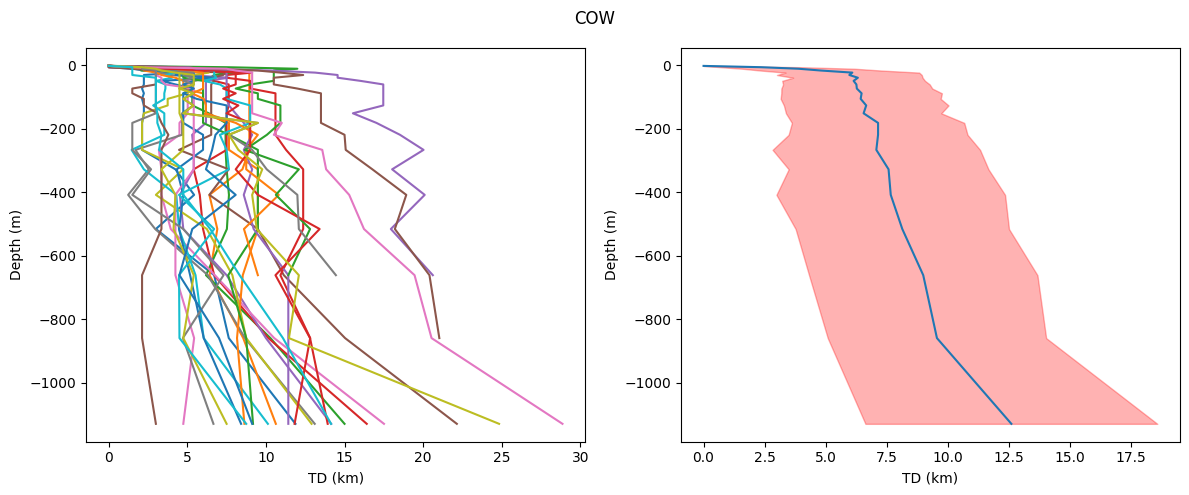

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in COW_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(COW_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(COW_TD_df['Mean'], COW_TD_df['Depth'])
axs[1].fill_betweenx(COW_TD_df['Depth'], COW_TD_df['Mean'] - COW_TD_df['StdDev'], COW_TD_df['Mean'] + COW_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('COW')
plt.tight_layout()
plt.show()

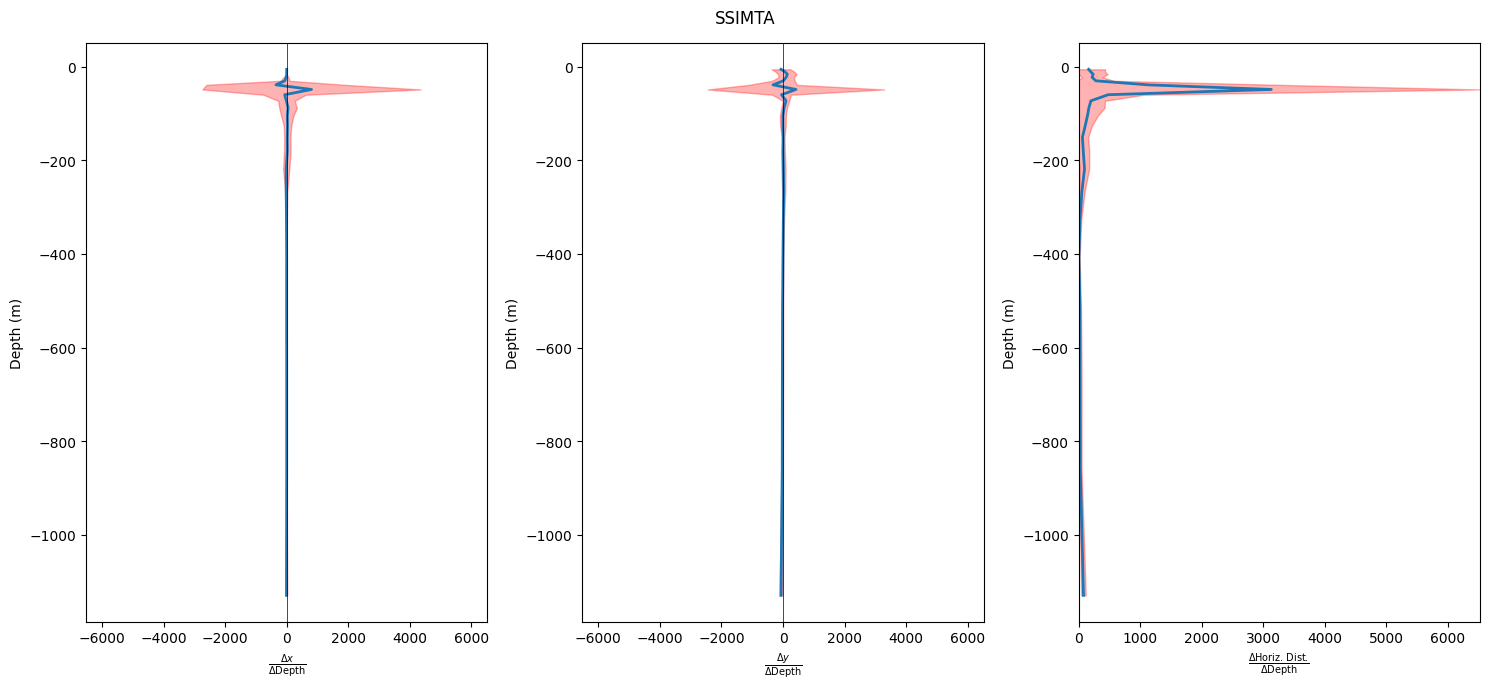

In [16]:
SSIMTA_x_df, SSIMTA_y_df, SSIMTA_x_diff_df, SSIMTA_y_diff_df, SSIMTA_TD_df, SSIMTA_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'SSIM')

max_x_value = max(
    np.nanmax(abs(SSIMTA_x_diff_df['Mean'] + SSIMTA_x_diff_df['StdDev'])),
    np.nanmax(abs(SSIMTA_y_diff_df['Mean'] + SSIMTA_y_diff_df['StdDev'])),
    np.nanmax(abs(SSIMTA_D_df['Mean'] + SSIMTA_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(SSIMTA_x_diff_df['Mean'], SSIMTA_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(SSIMTA_x_diff_df['Depth'], SSIMTA_x_diff_df['Mean'] - SSIMTA_x_diff_df['StdDev'], SSIMTA_x_diff_df['Mean'] + SSIMTA_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(SSIMTA_y_diff_df['Mean'], SSIMTA_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(SSIMTA_y_diff_df['Depth'], SSIMTA_y_diff_df['Mean'] - SSIMTA_y_diff_df['StdDev'], SSIMTA_y_diff_df['Mean'] + SSIMTA_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(SSIMTA_D_df['Mean'], SSIMTA_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(SSIMTA_D_df['Depth'], SSIMTA_D_df['Mean'] - SSIMTA_D_df['StdDev'], SSIMTA_D_df['Mean'] + SSIMTA_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('SSIMTA')
plt.tight_layout()
plt.show()

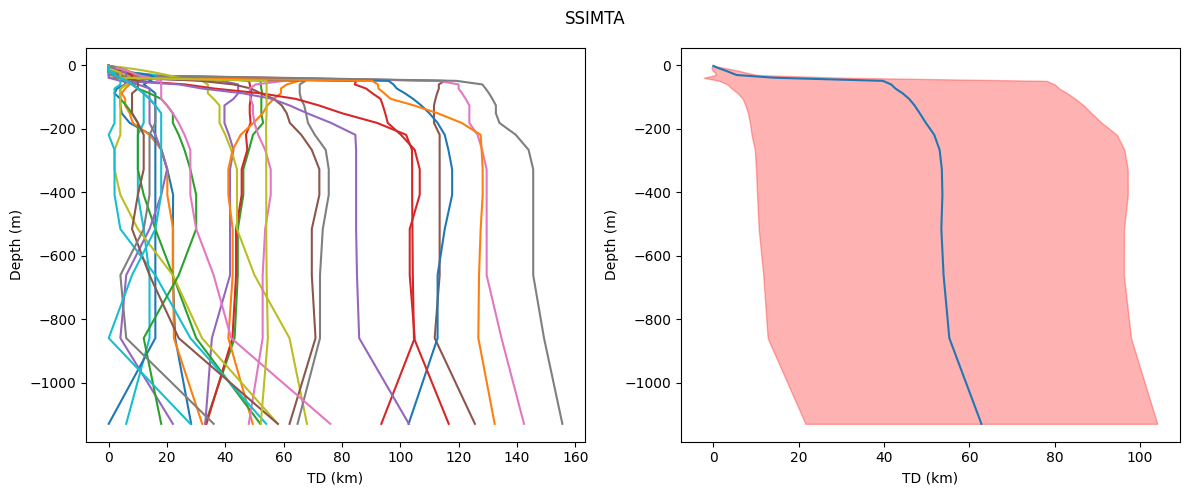

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in SSIMTA_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(SSIMTA_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(SSIMTA_TD_df['Mean'], SSIMTA_TD_df['Depth'])
axs[1].fill_betweenx(SSIMTA_TD_df['Depth'], SSIMTA_TD_df['Mean'] - SSIMTA_TD_df['StdDev'], SSIMTA_TD_df['Mean'] + SSIMTA_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('SSIMTA')
plt.tight_layout()
plt.show()


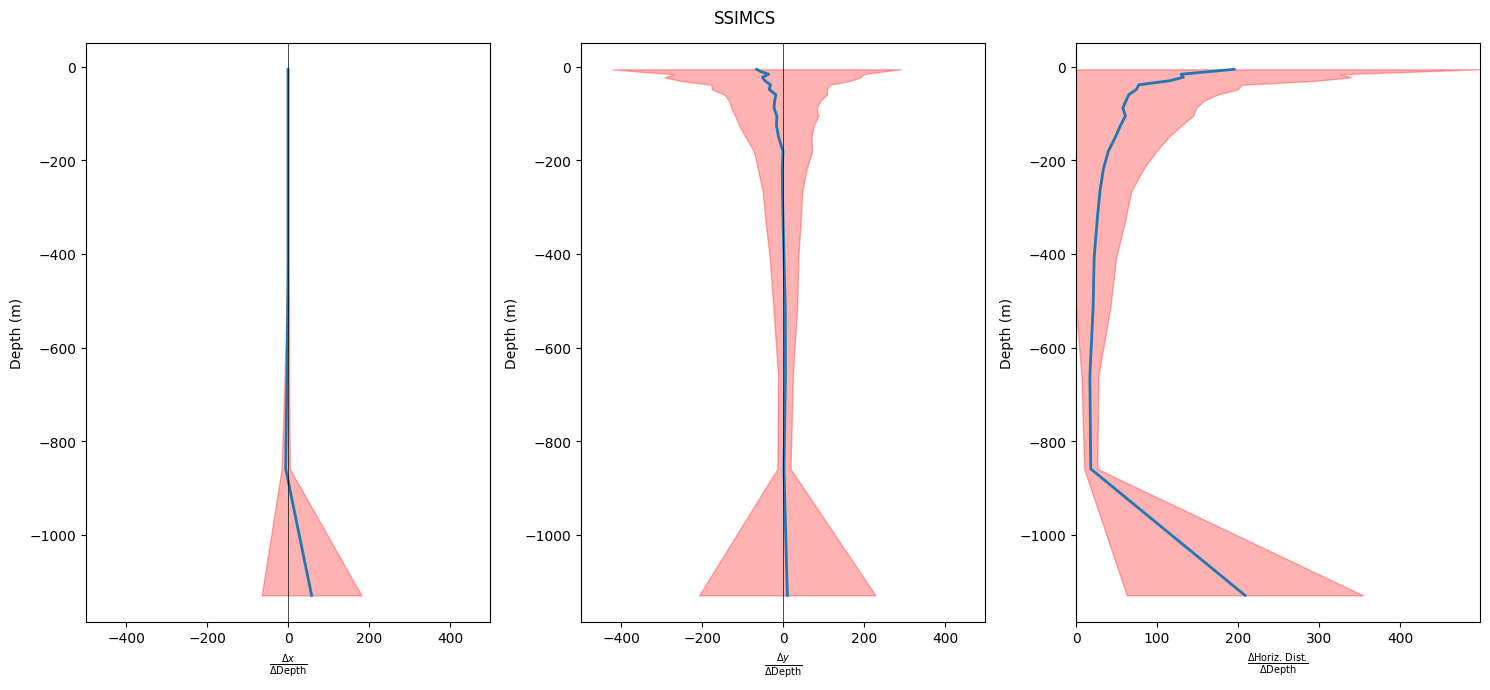

In [18]:
SSIMCS_x_df, SSIMCS_y_df, SSIMCS_x_diff_df, SSIMCS_y_diff_df, SSIMCS_TD_df, SSIMCS_D_df = process_eddy_data(sample_data, eddy, z_r[150, 150, :DEPTH_LVL_LIMIT]/1000, DEPTH_LVL_LIMIT, 'SSIMCS')

max_x_value = max(
    np.nanmax(abs(SSIMCS_x_diff_df['Mean'] + SSIMCS_x_diff_df['StdDev'])),
    np.nanmax(abs(SSIMCS_y_diff_df['Mean'] + SSIMCS_y_diff_df['StdDev'])),
    np.nanmax(abs(SSIMCS_D_df['Mean'] + SSIMCS_D_df['StdDev']))
)

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

# Plot for Delta x / Depth
axs[0].plot(SSIMCS_x_diff_df['Mean'], SSIMCS_x_diff_df['Depth'], linewidth=2)
axs[0].fill_betweenx(SSIMCS_x_diff_df['Depth'], SSIMCS_x_diff_df['Mean'] - SSIMCS_x_diff_df['StdDev'], SSIMCS_x_diff_df['Mean'] + SSIMCS_x_diff_df['StdDev'], color='r', alpha=0.3)
axs[0].set_xlabel(r'$\frac{\Delta x}{ \Delta \text{Depth}}$')
axs[0].set_ylabel('Depth (m)')
axs[0].axvline(x=0, color='k', linewidth=0.5)
axs[0].set_xlim([-max_x_value, max_x_value])

# Plot for Delta y / Depth
axs[1].plot(SSIMCS_y_diff_df['Mean'], SSIMCS_y_diff_df['Depth'], linewidth=2)
axs[1].fill_betweenx(SSIMCS_y_diff_df['Depth'], SSIMCS_y_diff_df['Mean'] - SSIMCS_y_diff_df['StdDev'], SSIMCS_y_diff_df['Mean'] + SSIMCS_y_diff_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel(r'$\frac{\Delta y}{ \Delta \text{Depth}}$')
axs[1].set_ylabel('Depth (m)')
axs[1].axvline(x=0, color='k', linewidth=0.5)
axs[1].set_xlim([-max_x_value, max_x_value])

# Plot for Delta Horizontal Distance / Depth
axs[2].plot(SSIMCS_D_df['Mean'], SSIMCS_D_df['Depth'], linewidth=2)
axs[2].fill_betweenx(SSIMCS_D_df['Depth'], SSIMCS_D_df['Mean'] - SSIMCS_D_df['StdDev'], SSIMCS_D_df['Mean'] + SSIMCS_D_df['StdDev'], color='r', alpha=0.3)
axs[2].set_xlabel(r'$\frac{\Delta \text{Horiz. Dist.}}{ \Delta \text{Depth}}$')
axs[2].set_ylabel('Depth (m)')
axs[2].axvline(x=0, color='k', linewidth=0.5)
axs[2].set_xlim([0, max_x_value])

# Plot title and layout
plt.suptitle('SSIMCS')
plt.tight_layout()
plt.show()

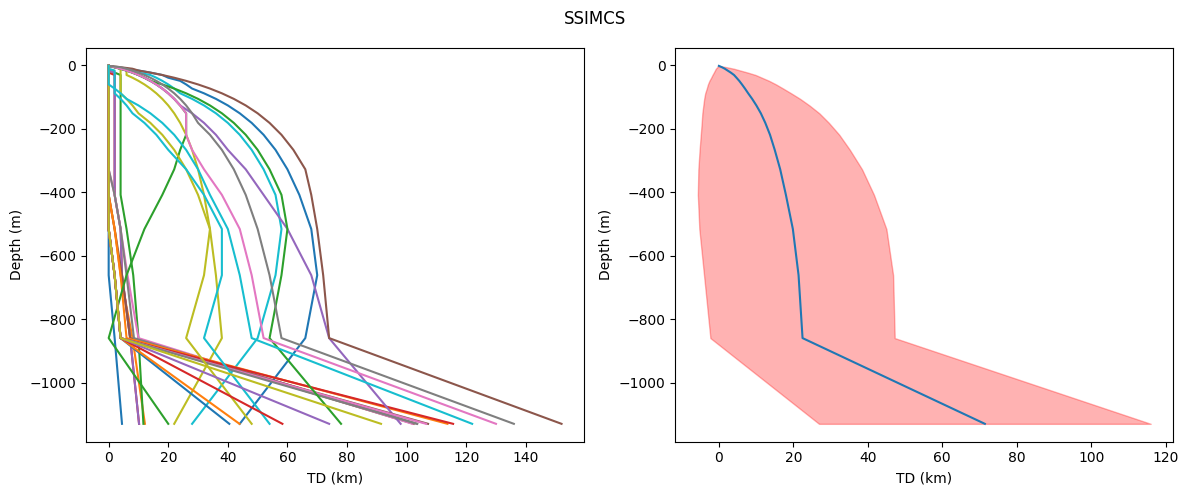

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for key in SSIMCS_TD_df.keys():
    if key not in ['Depth', 'Mean', 'StdDev']:
        axs[0].plot(SSIMCS_TD_df[key], z_r[150, 150, :DEPTH_LVL_LIMIT])
axs[0].set_xlabel('TD (km)')
axs[0].set_ylabel('Depth (m)')

axs[1].plot(SSIMCS_TD_df['Mean'], SSIMCS_TD_df['Depth'])
axs[1].fill_betweenx(SSIMCS_TD_df['Depth'], SSIMCS_TD_df['Mean'] - SSIMCS_TD_df['StdDev'], SSIMCS_TD_df['Mean'] + SSIMCS_TD_df['StdDev'], color='r', alpha=0.3)
axs[1].set_xlabel('TD (km)')
axs[1].set_ylabel('Depth (m)')

plt.suptitle('SSIMCS')
plt.tight_layout()
plt.show()
